In [1]:
import sys
import time
import torch
import torch.nn as nn
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
from os.path import join

sys.path.append('/home/agajan/DeepMRI')
from deepmri import Datasets, CustomLosses, utils, visutils  # noqa: E402
from DiffusionMRI.models.MultiScale import Encoder, Decoder  # noqa: E402  # noqa: E402

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [3]:
subj_id = "784565"
experiment_dir = '/home/agajan/experiment_DiffusionMRI/'
data_path = join(experiment_dir, "tractseg_data", subj_id, "training_slices/coronal/")
model_name = "MultiScale"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # device
deterministic = True  # reproducibility
seed = 0  # random seed for reproducibility
if deterministic:
    torch.manual_seed(seed)
torch.backends.cudnn.benchmark = not deterministic  # set False whenever input size varies
torch.backends.cudnn.deterministic = deterministic

# data
batch_size = 1

# noise probability
noise_prob = None

start_epoch = 10  # for loading pretrained weights

### Data

In [4]:
origset = Datasets.OrientationDataset(data_path, scale=False, normalize=False, bg_zero=False)
trainset = Datasets.OrientationDataset(data_path, scale=True, normalize=False, bg_zero=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=10)
print("Total training examples: {}, Batch size: {}, Iters per epoch: {}".format(len(trainset),
                                                                                batch_size,
                                                                                len(trainloader)))

Total training examples: 142, Batch size: 1, Iters per epoch: 142


### Load Model

In [5]:
encoder = Encoder(input_size=(145, 145))
decoder = Decoder()
encoder.to(device)
decoder.to(device)

if start_epoch != 0:
    encoder_path = "{}/saved_models/{}_encoder_epoch_{}".format(experiment_dir, model_name, start_epoch)
    decoder_path = "{}/saved_models/{}_decoder_epoch_{}".format(experiment_dir, model_name, start_epoch)
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))
    print("Loaded pretrained weights starting from epoch {}".format(start_epoch))

p1 = utils.count_model_parameters(encoder)
p2 = utils.count_model_parameters(decoder)
print("Total parameters: {}, trainable parameters: {}".format(p1[0] + p2[0], p1[1] + p2[1]))

# criterion and optimizer settings
criterion = CustomLosses.MaskedLoss()
masked_loss = True

encoder.eval()
decoder.eval()

print("Ok")

Loaded pretrained weights starting from epoch 10
Total parameters: 790968, trainable parameters: 790968
Ok


## Show Reconstructions

In [6]:
inputs = []
features = []
outputs = []
losses = []
diff_imgs = []

with torch.no_grad():
    for batch in trainloader:
        x = batch["data"].to(device)
        feature = encoder(x)
        y = decoder(feature)
        mask = batch['mask'].unsqueeze(1).to(device)
        loss = criterion(y, x, mask)
        losses.append(loss.item())
        
        y = y.detach().cpu().squeeze()
        x = x.detach().cpu().squeeze()
        h = feature.detach().cpu().squeeze()
        y[:, batch['mask'].squeeze() == 0] = 0
        x[:, batch['mask'].squeeze() == 0] = 0
        
        diff_imgs.append(x-y)
        
        
        inputs.append(x)
        features.append(h)
        outputs.append(y)

In [1]:
idx = 55

input_slices = [inputs[idx][0].T, inputs[idx][1].T, inputs[idx][2].T, inputs[idx][3].T]
output_slices = [outputs[idx][0].T, outputs[idx][1].T, outputs[idx][2].T, outputs[idx][3].T]
diff_slices = [diff_imgs[idx][0].T, diff_imgs[idx][1].T, diff_imgs[idx][2].T, diff_imgs[idx][3].T]

for i in range(1):
    diff_slices[i] = diff_slices[i].clamp(min=-diff_slices[i].max())

titles = [r"b=0 $s/mm^2$", r"b=1000 $s/mm^2$", r"b=2000 $s/mm^2$", r"b=3000 $s/mm^2$"]
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes[0][0].set_ylabel("Original input", fontsize=14)
axes[1][0].set_ylabel("Reconstruction", fontsize=14)
axes[2][0].set_ylabel("Difference image", fontsize=14)
plt.subplots_adjust(hspace=0.4)

for i in range(4):
    pcm = axes[0][i].imshow(input_slices[i], origin="lower", cmap="gray")
    axes[0][i].set_xticks([])
    axes[0][i].set_yticks([])
    axes[0][i].set_yticks([])
    axes[0][i].set_title(titles[i], size=14)
    axes[0][i].set_xlabel("Max. value: {:.5f}".format(input_slices[i].max().item()), size=14)
    fig.colorbar(pcm, ax=axes[0][i])

for i in range(4):
    pcm = axes[1][i].imshow(output_slices[i], origin="lower", cmap="gray")
    axes[1][i].set_xticks([])
    axes[1][i].set_yticks([])
    axes[1][i].set_title("MSE: {:.5f}".format(losses[i]), size=14)
    axes[1][i].set_xlabel("Max. value: {:.5f}".format(output_slices[i].max().item()), size=14)
    fig.colorbar(pcm, ax=axes[1][i])

for i in range(4):
    elev_min = diff_slices[i].min()
    elev_max = diff_slices[i].max()
    mid_val = 0
    pcm = axes[2][i].imshow(diff_slices[i], origin="lower", cmap="RdBu_r", 
                            clim=(elev_min, elev_max), 
                            norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
    axes[2][i].set_xticks([])
    axes[2][i].set_yticks([])
#     axes[1][i].set_title("MSE: {:.5f}".format(losses[i]), size=14)
#     axes[1][i].set_xlabel("Max. value: {:.5f}".format(output_slices[i].max().item()), size=14)
    fig.colorbar(pcm, ax=axes[2][i])

NameError: name 'inputs' is not defined

## Show features

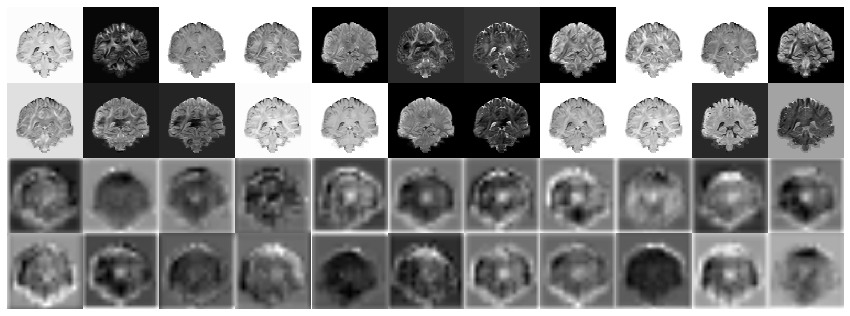

In [19]:
images = [f for f in features[idx]]
fig = plt.figure(figsize=(15, 5.55))
axes = [fig.add_subplot(4, 11, i+1) for i in range(len(images))]
for c, ax in enumerate(axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.imshow(images[c].T, origin="lower", cmap="gray")
    ax.axis('off')
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

 ### PCA Feature maps

In [21]:
pca_pth = join(experiment_dir, "tractseg_data", subj_id, "unnorm_voxels_pca_nc_10.npz")
pca_features = np.load(pca_pth)["data"]
print(pca_features.shape)

(145, 174, 145, 10)


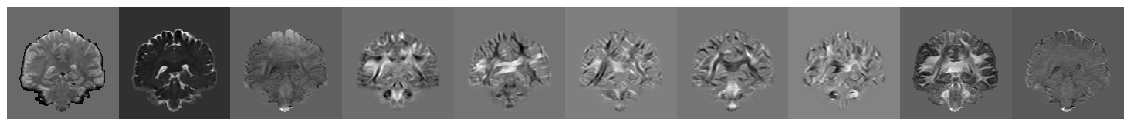

In [43]:
pf = pca_features[:, 72, :]
images = [pf[:, :, i] for i in range(pf.shape[2])]
# 10x4.1
fig = plt.figure(figsize=(20, 10))
axes = [fig.add_subplot(1, 10, i+1) for i in range(len(images))]
for c, ax in enumerate(axes):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.imshow(images[c].T, origin="lower", cmap="gray")
    ax.axis('off')
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()